<a href="https://colab.research.google.com/github/AchrafAsh/best-istanbul-datathon/blob/main/istanbul_datathon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Datathon 2021

The aim of this challenge is to predict today's wind power production (05/06/2021 00:00 --> 05/06/2021 23:00). 

To do so, we use forecast of weather conditions, which mos

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime

plt.rcParams.update({'figure.figsize': (8, 5), 'figure.dpi': 120})

np.random.seed(42)

### Processing of the provider dataframes

In [ ]:
# dataset filepaths
path_provider_1 = "https://raw.githubusercontent.com/AchrafAsh/best-istanbul-datathon/main/Provider1_Usecase2.csv"
path_provider_2 = "https://raw.githubusercontent.com/AchrafAsh/best-istanbul-datathon/main/Provider2_Usecase2.csv"
path_provider_3 = "https://raw.githubusercontent.com/AchrafAsh/best-istanbul-datathon/main/Provider3_Usecase2.csv"
path_generation = "https://raw.githubusercontent.com/AchrafAsh/best-istanbul-datathon/main/ActualGeneration_Usecase2_v2.csv"

In [ ]:
# format date
def format_date(date:int):
    date_string = str(date)
    year = date_string[:4]
    month = date_string[4:6]
    day = date_string[6:]
    # convert to datetime
    return f"{year}-{month}-{day}"

In [ ]:
def get_provider_data(path: str):
    df_provider = pd.read_csv(path, sep=";")
    # change column names
    df_provider.rename(columns={ "Datekey": "date",
                                "ProviderId": "provider_id",
                                "Hour": "hour",
                                "WindSpeed": "wind_speed",
                                "WindDirection": "wind_direction",
                                "Temperature": "temperature",
                                "Pressure": "pressure",
                                "Humidity": "humidity",
                                "PowerWOAvailability": "power"},
                        inplace=True)
    # format date
    df_provider["date"] = df_provider["date"].apply(format_date)
    # aggregate date and hour
    df_provider["date"] = df_provider["date"] + "T" + df_provider["hour"]
    # convert to datetime object
    df_provider["date"] = df_provider.date.apply(
        lambda d: datetime.strptime(d,"%Y-%m-%dT%H:%M")
        )
    # sinusoidal signal for hour
    df_provider.loc[:,'hour'] = [ int(hour[0:2]) for hour in df_provider['hour'] ]
    df_provider['hour_sin'] = np.sin(2 * np.pi * df_provider['hour']/23.0)
    df_provider['hour_cos'] = np.cos(2 * np.pi * df_provider['hour']/23.0)

    # drop hour column
    df_provider.drop(columns=["hour"], inplace=True)
    return df_provider

In [ ]:
provider_1 = get_provider_data(path_provider_1)
provider_2 = get_provider_data(path_provider_2)
provider_3 = get_provider_data(path_provider_3)

In [ ]:
def get_actual_generation():
    filepath = "https://raw.githubusercontent.com/AchrafAsh/best-istanbul-datathon/main/ActualGeneration_Usecase2_v2.csv"
    actual_generation = pd.read_csv(filepath, sep=";", parse_dates=["PCTimeStamp"])
    actual_generation.rename(columns={"PCTimeStamp": "date",
                                  "PowerMWh": "power"},
                            inplace=True)
    
    
    actual_generation.replace(float("inf"), np.nan, inplace=True)
    actual_generation.fillna(method="ffill", inplace=True)
    
    return actual_generation

In [ ]:
'''
averaging_function 

input :
- list of dataframes (provider_i for i in 1,2,3)

returns :
- unique dataframe with same columns, no nans, average of meteo and power data
'''

def average_forecasts(list_of_providers):
    
    # Meteorological data 
    
    provider_1 = list_of_providers[0]
    provider_2 = list_of_providers[1]
    provider_3 = list_of_providers[2]
    
    provider_final_df = pd.DataFrame(index = list(provider_1.index), columns = list(provider_1.columns))
    
    provider_final_df.date = provider_1.date
    
    del provider_final_df['provider_id']
    
    for column in list(provider_final_df.columns):
        
        if column != 'date':
        
            to_average = pd.DataFrame() 
            to_average[column+'_1'] = provider_1[column]
            to_average[column+'_2'] = provider_2[column]
            to_average[column+'_3'] = provider_3[column]

            provider_final_df[column] = to_average.mean(axis = 1)
    
    return(provider_final_df)

In [ ]:
average_provider = average_forecasts([provider_1, provider_2, provider_3])

In [ ]:
### Processing of the Actual generation dataframe

In [ ]:
actual_generation = get_actual_generation()

### Visualization

[Text(0.5, 1.0, 'Forecasted and actual production (7 days)')]

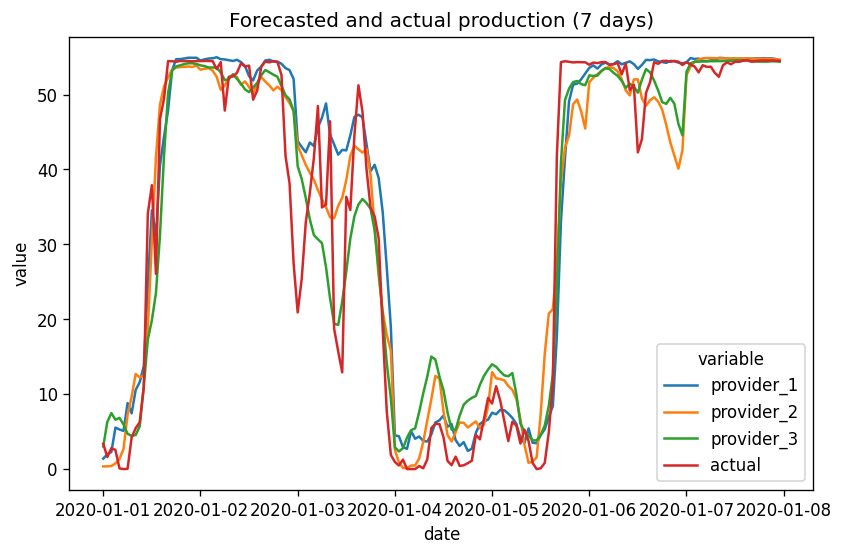

In [ ]:
# visualize forecasted and actual productions
data = pd.DataFrame({
    "date": actual_generation.date[:168],
    "provider_1": provider_1[:168]["power"],
    "provider_2": provider_2[:168]["power"],
    "provider_3": provider_3[:168]["power"],
    "actual": actual_generation["power"],
})

sns.lineplot(x="date", y="value", hue="variable",
             data=pd.melt(data, ["date"])).set(title="Forecasted and actual production (7 days)")

[Text(0.5, 1.0, 'Average forecasted and actual production (7 days)')]

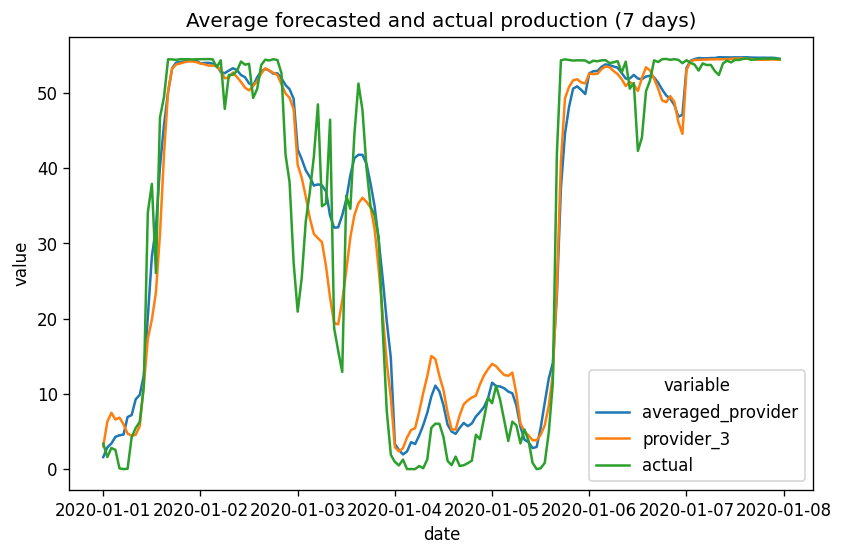

In [ ]:
# visualize forecasted and actual productions
data = pd.DataFrame({
    "date": actual_generation.date[:168],
    "averaged_provider": average_provider[:168]["power"],
    "provider_3": provider_3[:168]["power"],
    "actual": actual_generation["power"],
})

sns.lineplot(x="date", y="value", hue="variable",
             data=pd.melt(data, ["date"])).set(title="Average forecasted and actual production (7 days)")



### Comparing the quality of the four forecasts

In [ ]:
def compare_forecasts(list_of_forecasts, actual):
  for forecast in list_of_forecasts:

    print('MSE of {forecast} is {rmse}'.format(forecast = 'forecast', rmse = ((forecast[:168].power - actual[:168].power) ** 2).mean() ** 0.5))

In [ ]:
compare_forecasts([provider_1, provider_2, provider_3, average_provider], actual_generation)

MSE of forecast is 6.935762520415258
MSE of forecast is 6.5225388737236
MSE of forecast is 6.3139926987165484
MSE of forecast is 5.807227581587172


In [ ]:
### Splits

In [57]:
X = average_provider.drop(['power','date'], axis = 1)[:-24]
y = actual_generation['power']

X_test = average_provider.drop(['power','date'], axis = 1)[-24:]
y_test = average_provider['power'][-24:]

print(len(X))
print(len(y))
print(len(y_test))

from sklearn.model_selection import train_test_split 

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size = 0.1, random_state = 42, shuffle = False
)

12504
12504
24


In [ ]:
print(X_train.info())
print(X_val.info())
print('\n' + 'Length of y_test: ' + str(len(y_test)))
print('\n' + 'Length of y_val: ' + str(len(y_val)))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11253 entries, 0 to 11252
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   wind_speed      11253 non-null  float64
 1   wind_direction  11253 non-null  float64
 2   temperature     11253 non-null  float64
 3   pressure        11253 non-null  float64
 4   humidity        11253 non-null  float64
 5   hour_sin        11253 non-null  float64
 6   hour_cos        11253 non-null  float64
dtypes: float64(7)
memory usage: 703.3 KB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1251 entries, 11253 to 12503
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   wind_speed      1251 non-null   float64
 1   wind_direction  1251 non-null   float64
 2   temperature     1251 non-null   float64
 3   pressure        1251 non-null   float64
 4   humidity        1251 non-null   float64
 5   hour_sin 

In [ ]:
print(X_train)
print(X_val)

       wind_speed  wind_direction  temperature  ...   humidity  hour_sin  hour_cos
0        1.500000      313.000000     5.650000  ...  80.570000  0.000000  1.000000
1        1.450000      260.000000     5.550000  ...  79.700000  0.269797  0.962917
2        2.000000      251.500000     4.900000  ...  78.840000  0.519584  0.854419
3        2.100000      264.500000     4.800000  ...  77.980000  0.730836  0.682553
4        2.100000      276.000000     4.700000  ...  75.210000  0.887885  0.460065
...           ...             ...          ...  ...        ...       ...       ...
11248    2.216667       39.953333    14.456667  ...  21.264000 -0.942261 -0.334880
11249    2.053333       44.560000    14.276667  ...  21.327333 -0.997669 -0.068242
11250    1.970000       61.880000    14.096667  ...  21.388333 -0.979084  0.203456
11251    2.023333       84.863333    13.713333  ...  21.782667 -0.887885  0.460065
11252    1.973333      119.513333    13.353333  ...  22.177000 -0.730836  0.682553

[11

## Linear Regression

[Text(0.5, 1.0, 'Feature correlation')]

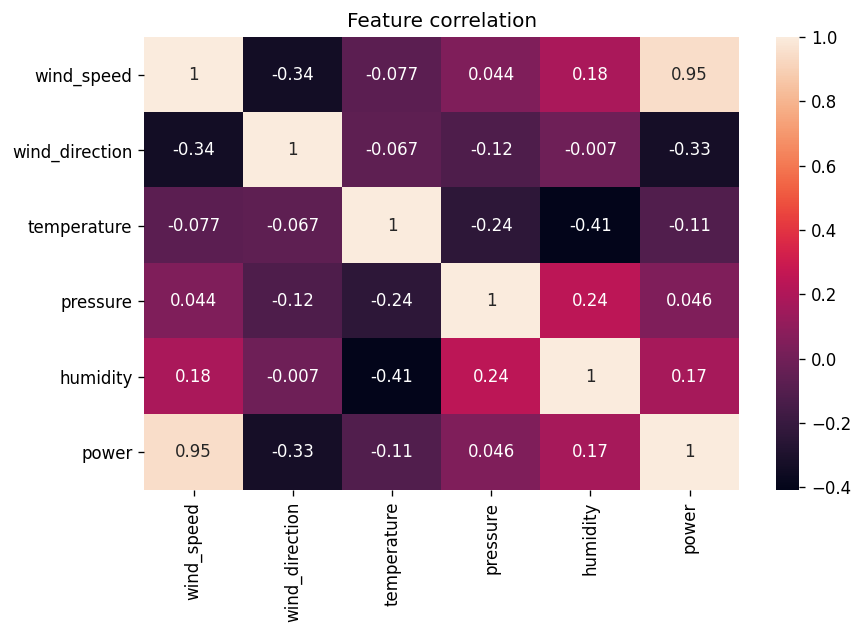

In [49]:
sns.heatmap(average_provider.corr(), annot=True).set(title="Feature correlation")

`wind_speed` is the only feature that is strongly correlated with the production so we can try to fit a very basic linear regression:

[Text(0.5, 1.0, 'Power production w.r.t wind speed')]

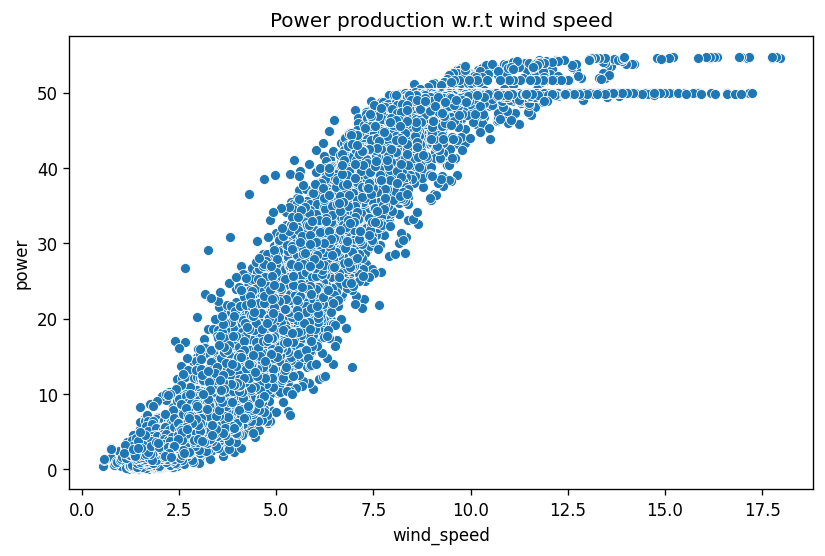

In [54]:
sns.scatterplot(x="wind_speed", y="power", data=average_provider).set(title="Power production w.r.t wind speed")

In [55]:
from sklearn.linear_model import LinearRegression

In [59]:
reg = LinearRegression()
reg.fit(X=np.array(X_train["wind_speed"]).reshape(-1, 1), y=y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [62]:
train_mae = np.mean(np.abs(reg.predict(np.array(X_train["wind_speed"]).reshape(-1, 1)) - y_train))
print(f"Train MAE: {train_mae} | train R²: {reg.score(np.array(X_train['wind_speed']).reshape(-1, 1), y_train)}")

Train MAE: 7.848399057026317 | train R²: 0.7340595317095971


In [64]:
valid_mae = np.mean(np.abs(reg.predict(np.array(X_val['wind_speed']).reshape(-1, 1)) - y_val))
print(f"Valid MAE: {valid_mae} | valid R²: {reg.score(X=np.array(X_val['wind_speed']).reshape(-1,1), y=y_val)}")

Valid MAE: 7.742309843943446 | valid R²: 0.5737251906829863


In [65]:
test_mae = np.mean(np.abs(reg.predict(np.array(X_test['wind_speed']).reshape(-1, 1)) - y_test))
print(f"Test MAE: {test_mae} | valid R²: {reg.score(X=np.array(X_test['wind_speed']).reshape(-1,1), y=y_test)}")

Test MAE: 1.624165378134281 | valid R²: 0.5322968616723067


## ARIMA

In [66]:
%%capture
!pip install statsmodels
import statsmodels.api as sm

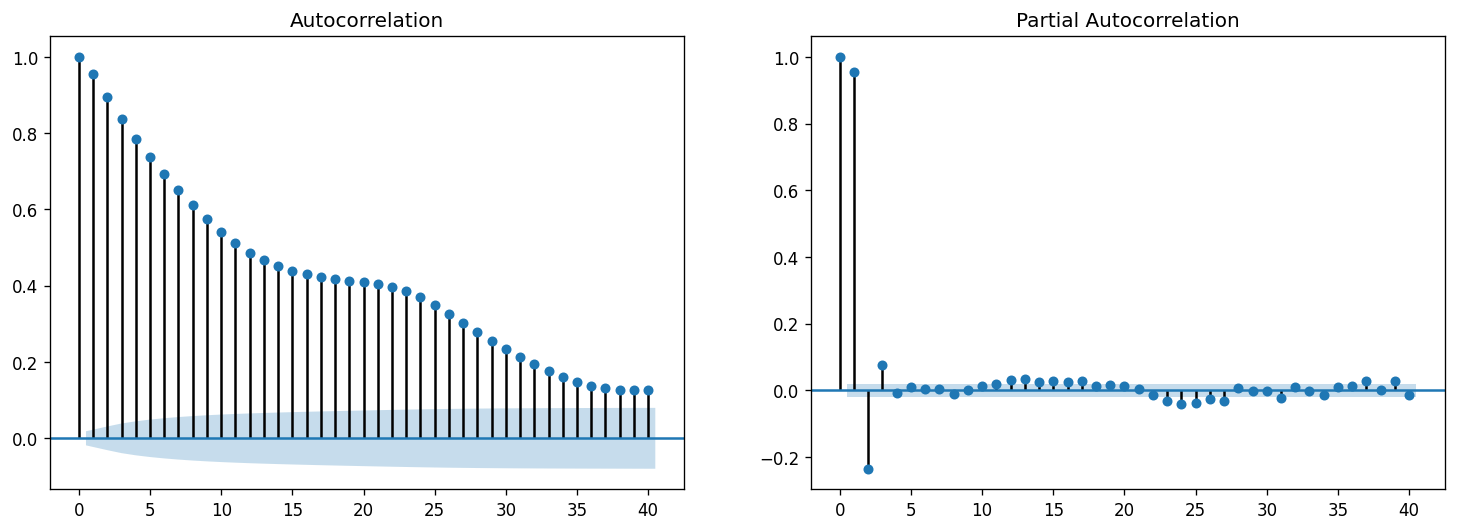

In [122]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(121)
fig = sm.graphics.tsa.plot_acf(y_train, lags=40, ax=ax1)
ax2 = fig.add_subplot(122)
fig = sm.graphics.tsa.plot_pacf(y_train, lags=40, ax=ax2)

In [129]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(y_train.values)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -11.441802
p-value: 0.000000


The p-value is less than 0.05 so we don't need to differentiate (our signal is already stationnary).

In [130]:
arima = sm.tsa.ARIMA(y_train, order=(3, 0, 0))
res = arima.fit()

In [131]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                  power   No. Observations:                11253
Model:                     ARMA(3, 0)   Log Likelihood              -35459.858
Method:                       css-mle   S.D. of innovations              5.652
Date:                Sat, 05 Jun 2021   AIC                          70929.716
Time:                        18:55:39   BIC                          70966.358
Sample:                             0   HQIC                         70942.046
                                                                              
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          22.9291      1.064     21.551      0.000      20.844      25.014
ar.L1.power     1.1981      0.009    127.465      0.000       1.180       1.216
ar.L2.power    -0.3236      0.014    -22.513      0.000      -0.352      -0.295
ar.L3.power     0.0755      0.009      8.034      0.000       0.057       0.094
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0648           -0.0000j            1.0648           -0.0000
AR.2            1.6102           -3.1374j            3.5265           -0.1745
AR.3            1.6102           +3.1374j            3.5265            0.1745
-----------------------------------------------------------------------------
"""

We obtained the best model (according to the **AIC**) with an ARIMA(3, 0, 0).

The p-values of the AR3 are all highly significant (<< 0.05).

In [76]:
preds_train = arima.predict(res.params, start=0, end=11252)
preds_val = arima.predict(res.params, start=11253, end=12503)
preds_test = arima.predict(res.params, start=12504, end=12527)

In [77]:
train_mae = np.mean(np.abs(preds_train - y_train.values))
val_mae = np.mean(np.abs(preds_val - y_val.values))
test_mae = np.mean(np.abs(preds_test[-24:] - y_test.values))

print(f"Train MAE: {train_mae} \nValidation MAE: {val_mae} \nTest MAE: {test_mae}")

Train MAE: 3.6226061129530036 
Validation MAE: 17.56753893034647 
Test MAE: 16.52806880126738


The **ARIMA** model can fit the training data accurately (MAE: 3.6, way better than the linear regression), but performs very poorly on the validation and test sets. Indeed, it the predictions are too smooth to get accurate predictions on an hourly basis:

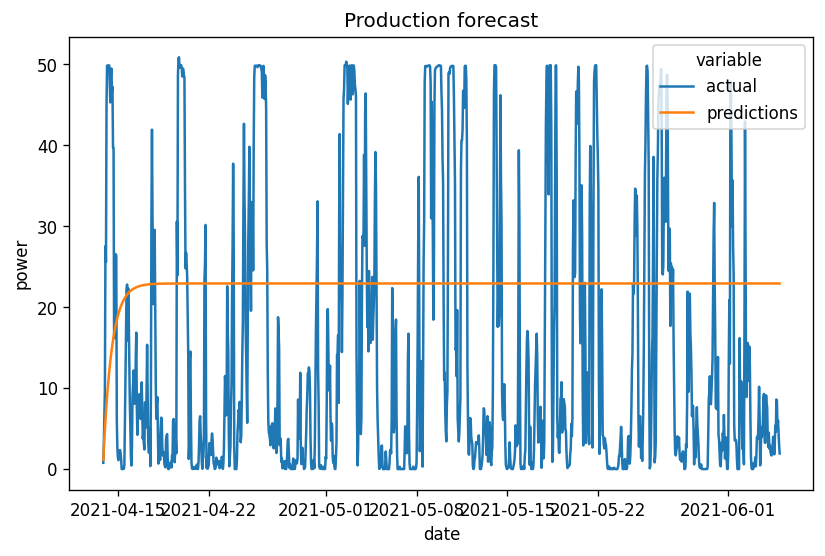

In [96]:
forecast_data = pd.DataFrame({
    "date": provider_1.loc[y_val.index.tolist()].date,
    "actual": y_val,
    "predictions": preds_val,
})

sns.lineplot(x="date", y="value", hue="variable",
             data=pd.melt(forecast_data, ["date"])).set(ylabel="power", title="Production forecast")

sns.lineplot()

## LSTM

In [ ]:
### scaling data

from sklearn.preprocessing import MinMaxScaler

x = X_train.values
min_max_scaler = MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
X_train_scaled = pd.DataFrame(x_scaled)
X_val_scaled = pd.DataFrame(min_max_scaler.transform(X_val.values))

In [ ]:
import tensorflow
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential


In [ ]:
X_tr = X_train_scaled.to_numpy().reshape((X_train.shape[0], 1, X_train.shape[1]))
X_va = X_val_scaled.to_numpy().reshape((X_val_scaled.shape[0], 1, X_val_scaled.shape[1]))

In [ ]:
# construct network
model = Sequential()
model.add(layers.LSTM(128, return_sequences=True, input_shape = (X_tr.shape[1],X_tr.shape[2])))
model.add(layers.Dropout(0.3))
model.add(layers.LSTM(128, return_sequences=True))
model.add(layers.Dropout(0.3))
model.add(layers.LSTM(128))
model.add(layers.Dense(1))

#compile network
model.compile(loss='mae', optimizer = 'adam')

# summary
model.summary()

# fit network
model_lstm = model.fit(X_tr, 
                      y_train, 
                      epochs=25, batch_size=64, 
                      shuffle=False, validation_data = (X_va, y_val))



Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 1, 128)            69632     
_________________________________________________________________
dropout_4 (Dropout)          (None, 1, 128)            0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 1, 128)            131584    
_________________________________________________________________
dropout_5 (Dropout)          (None, 1, 128)            0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 332,929
Trainable params: 332,929
Non-trainable params: 0
________________________________________________

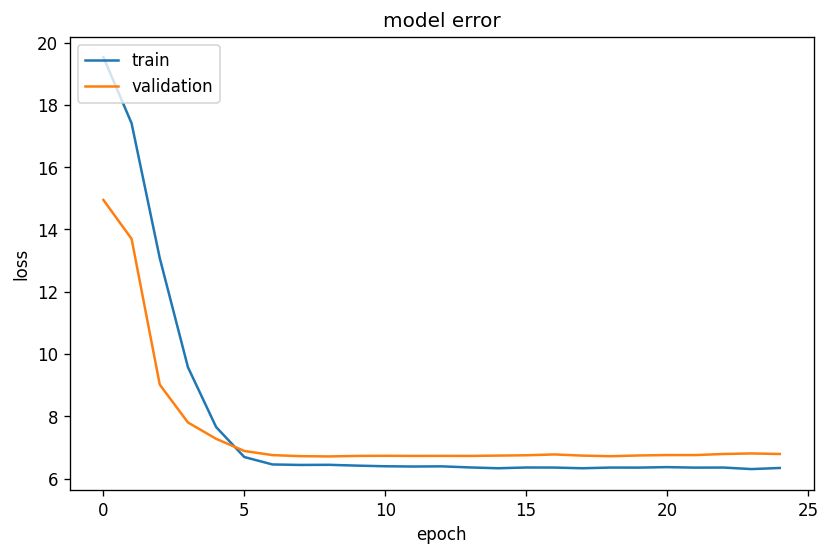

In [ ]:
#  "Loss"
plt.plot(model_lstm.history['loss'])
plt.plot(model_lstm.history['val_loss'])
plt.title('model error')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
# fitting a stepwise model to find the best paramters for SARIMA:
stepwise_fit = pm.auto_arima(target_final, start_p=1, start_q=1, max_p=3, max_d=2,max_q=3,m=7,
                             start_P=0,start_Q=0,max_P=3, max_D=3,max_Q=3, seasonal=True, trace=True,
                             error_action='ignore',  # don't want to know if an order does not work
                             suppress_warnings=True,  # don't want convergence warnings
                             stepwise=True)  # set to stepwisestepwise_fit.summary()
stepwise_fit.summary()